In [20]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as transforms

from torchvision import models
from torchvision.models import EfficientNet_B0_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")


Training on device cuda


# Creating Custom DataSet

In [12]:
class CellImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.labels = []
        self.image_paths = []
        self.transform = transform
        self.class_to_idx = {}

        for idx, class_name in enumerate(os.listdir(img_dir)):
            self.class_to_idx[class_name] = idx
            class_dir = os.path.join(img_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.labels.append(idx)
                    self.image_paths.append(img_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = read_image(self.image_paths[idx])
        image = transforms.ToPILImage()(image)  # Convert the tensor image to a PIL Image
        if self.transform:
            image = self.transform(image)
        return image, label

# Adapting EfficiNet to the Custom DataSet

In [13]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Defining Hyperparameters

In [14]:
img_dir = '../sub_images'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CellImageDataset(img_dir, transform=transform)

# Dividir o dataset em conjuntos de treino e teste mantendo a proporção de classes
train_indices, test_indices = train_test_split(
    range(len(dataset.labels)),
    test_size=0.2,
    random_state=42,
    stratify=dataset.labels
)

train_set = torch.utils.data.Subset(dataset, train_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

# Criar os dataloaders para os conjuntos de treino e teste
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


# Carregar modelo pré-treinado ResNet-18 e modificar a última camada
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_features = model.classifier[1].in_features
model.fc = nn.Linear(num_features, 6)  # Ajustar para o número de classes do dataset

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# Treinamento do modelo

In [15]:

import time

model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    start_time = time.time()
    
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    epoch_time = time.time() - start_time

    print(f'Epoch {epoch + 1}/{num_epochs} Epoch Loss: {epoch_loss:.4f} Epoch Acc: {epoch_acc:.4f} Time: {epoch_time:.2f}s')

Epoch 1/10 Epoch Loss: 0.9686 Epoch Acc: 0.6988 Time: 71.72s
Epoch 2/10 Epoch Loss: 0.6297 Epoch Acc: 0.7662 Time: 72.90s
Epoch 3/10 Epoch Loss: 0.5464 Epoch Acc: 0.8003 Time: 72.81s
Epoch 4/10 Epoch Loss: 0.4991 Epoch Acc: 0.8175 Time: 73.12s
Epoch 5/10 Epoch Loss: 0.4593 Epoch Acc: 0.8309 Time: 72.40s
Epoch 6/10 Epoch Loss: 0.4280 Epoch Acc: 0.8417 Time: 73.78s
Epoch 7/10 Epoch Loss: 0.3874 Epoch Acc: 0.8570 Time: 75.30s
Epoch 8/10 Epoch Loss: 0.3788 Epoch Acc: 0.8594 Time: 74.05s
Epoch 9/10 Epoch Loss: 0.3574 Epoch Acc: 0.8674 Time: 75.05s
Epoch 10/10 Epoch Loss: 0.3275 Epoch Acc: 0.8805 Time: 75.26s


In [16]:
    
# Salvar o modelo em um arquivo
torch.save(model.state_dict(), '../models/efficientnet_multiclass_fine_tuned.pth')

# Avaliação do modelo

Test Loss: 0.4767
Test Accuracy: 0.8413
Test Precision: 0.8455
Test Recall: 0.8413
Test F1 Score: 0.8413


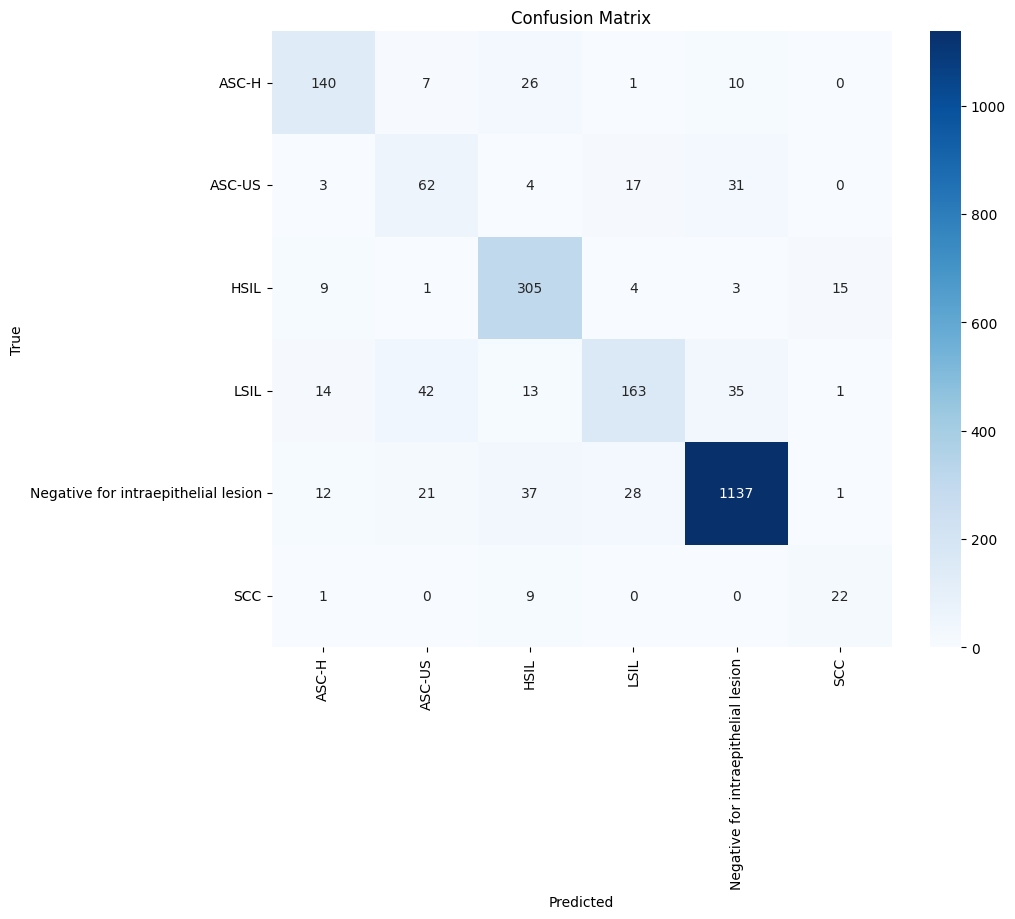

In [17]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, all_labels, all_preds = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Plot da matriz de confusão
plot_confusion_matrix(all_labels, all_preds, list(dataset.class_to_idx.keys()))

In [24]:
print(classification_report(all_labels, all_preds, target_names=['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Normal', 'SCC']))

              precision    recall  f1-score   support

       ASC-H       0.78      0.72      0.75       184
      ASC-US       0.46      0.48      0.47       117
        HSIL       0.74      0.92      0.82       337
        LSIL       0.71      0.60      0.65       268
      Normal       0.93      0.91      0.92      1236
         SCC       0.58      0.66      0.62        32

    accuracy                           0.83      2174
   macro avg       0.70      0.71      0.71      2174
weighted avg       0.83      0.83      0.83      2174



In [ ]:
# Plotar acurácia e perda
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(test_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(test_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upperleft')

plt.show()